In [38]:
!pip install catboost > None

In [39]:
!pip install shap > None

In [40]:
import shap

In [41]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [42]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

In [43]:
from catboost import CatBoostRegressor

In [44]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

In [45]:
from sklearn.metrics import make_scorer #для создания авторских метрик
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

In [46]:
from sklearn.model_selection import GridSearchCV

In [47]:
df = pd.read_csv(r'C:\Users\Ксения\Project\Megy\content\Sat_data.csv')

In [48]:
#category_list = ['Spehricity', 'Crystalline', 'Space group']
#for i in category_list:
#  df[i] = df[i].astype('category')

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Area/volume                    561 non-null    float64
 1   Max/min                        561 non-null    float64
 2   org_coating_HAcceptors         561 non-null    float64
 3   org_coating_LogP               561 non-null    float64
 4   common_spin                    561 non-null    float64
 5   Eff_anisotropy_const           561 non-null    float64
 6   Magnetic_anisotropy            561 non-null    float64
 7   Magnetocrystalline_anisotropy  561 non-null    float64
 8   Anisotropy constant            561 non-null    float64
 9   Crystalline                    561 non-null    float64
 10  MAE                            561 non-null    float64
 11  Curie_temperature              561 non-null    float64
 12  Spehricity                     561 non-null    flo

# Модели и сравнение

In [50]:
X = df.drop('Saturation_magnetization', axis=1)  #Без целевой переменной
y = df['Saturation_magnetization']  #Целевая переменная

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [52]:
# Модели
models = [
    LinearRegression(),
    Ridge(),
    Lasso(),
    ElasticNet(),
    RandomForestRegressor(n_estimators=100, random_state=42),
    GradientBoostingRegressor(n_estimators=100, random_state=42),
    AdaBoostRegressor(n_estimators=100, random_state=42),
    BaggingRegressor(n_estimators=100, random_state=42),
    SVR(),
    KNeighborsRegressor(),
    MLPRegressor(max_iter=500)]

In [53]:
# Сохраняем результаты в список
results = []

# Нужно оценить каждую модель
for model in models:
    model.fit(X_train, y_train)  # Указываем категориальный признак
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Model': model.__class__.__name__,
        'MSE': mse,
        'RMSE': np.sqrt(mse),
        'R2': r2
    })

c:\Users\Ксения\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [54]:
df_results = pd.DataFrame(results)
print(df_results)

                        Model       MSE      RMSE        R2
0            LinearRegression  0.786064  0.886602  0.484420
1                       Ridge  0.817069  0.903919  0.464084
2                       Lasso  1.524655  1.234769 -0.000022
3                  ElasticNet  1.524655  1.234769 -0.000022
4       RandomForestRegressor  0.422442  0.649955  0.722920
5   GradientBoostingRegressor  0.430085  0.655809  0.717907
6           AdaBoostRegressor  0.758239  0.870769  0.502670
7            BaggingRegressor  0.424353  0.651424  0.721667
8                         SVR  1.028540  1.014170  0.325380
9         KNeighborsRegressor  0.641657  0.801035  0.579137
10               MLPRegressor  0.582782  0.763402  0.617753


C:\Users\Ксения\AppData\Local\Temp\ipykernel_14196\2909450855.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df_results['Model'], rotation=45, ha='right')
C:\Users\Ксения\AppData\Local\Temp\ipykernel_14196\2909450855.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(df_results['Model'], rotation=45, ha='right')
C:\Users\Ксения\AppData\Local\Temp\ipykernel_14196\2909450855.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(df_results['Model'], rotation=45, ha='right')


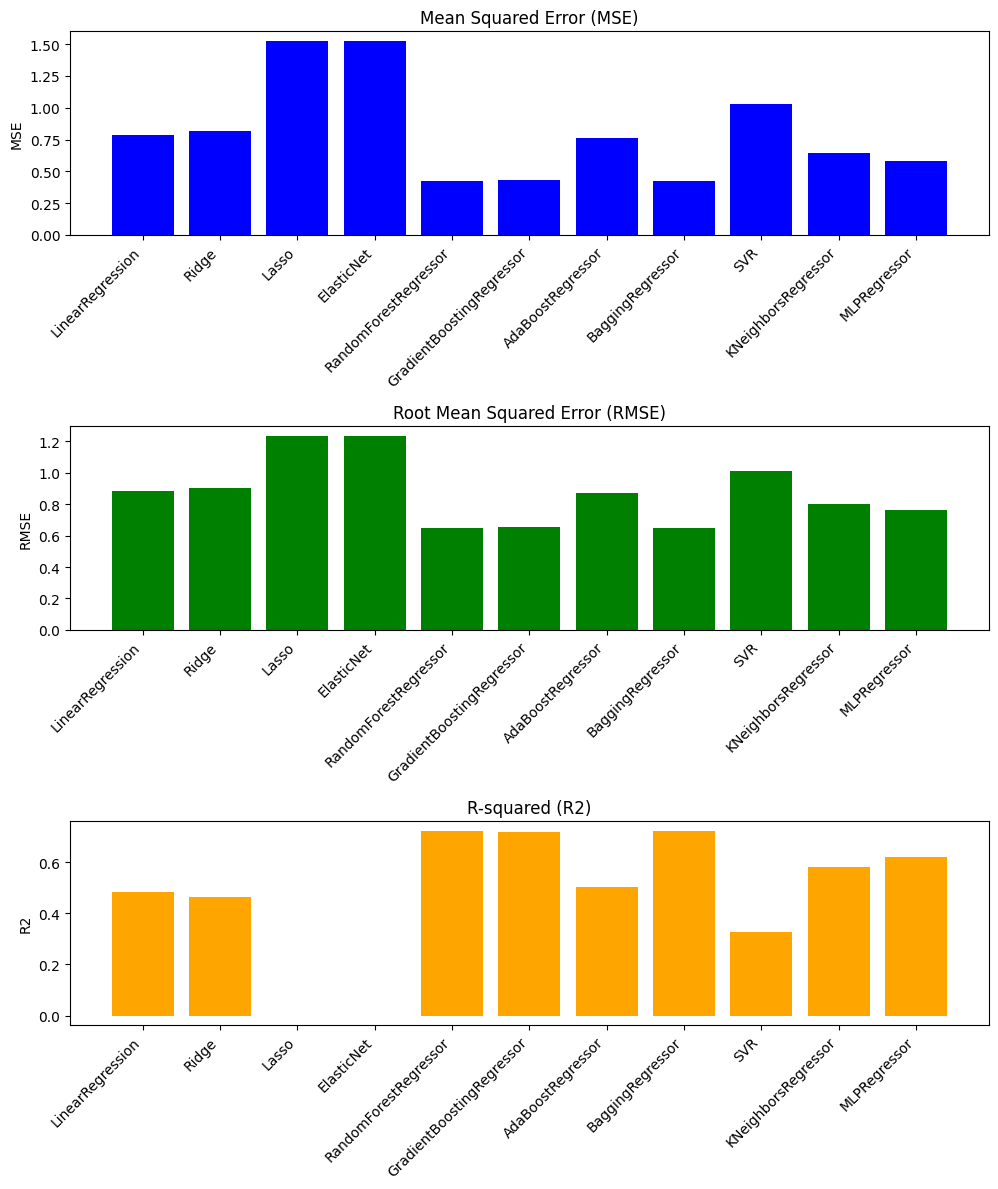

In [55]:
# Создаем фигуру и оси для графиков
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

# График среднеквадратичной ошибки (MSE)
ax1.bar(df_results['Model'], df_results['MSE'], color='blue')
ax1.set_title('Mean Squared Error (MSE)')
ax1.set_ylabel('MSE')
ax1.set_xticklabels(df_results['Model'], rotation=45, ha='right')

# График корня из среднеквадратичной ошибки (RMSE)
ax2.bar(df_results['Model'], df_results['RMSE'], color='green')
ax2.set_title('Root Mean Squared Error (RMSE)')
ax2.set_ylabel('RMSE')
ax2.set_xticklabels(df_results['Model'], rotation=45, ha='right')

# График коэффициента детерминации (R2)
ax3.bar(df_results['Model'], df_results['R2'], color='orange')
ax3.set_title('R-squared (R2)')
ax3.set_ylabel('R2')
ax3.set_xticklabels(df_results['Model'], rotation=45, ha='right')

# Регулируем расположение графиков
plt.tight_layout()

# Показываем графики
plt.show()

# Кроссвалидация RandomForest

In [56]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

# Создаем объект RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Выполняем кросс-валидацию
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

# Преобразуем отрицательные значения MSE в положительные
cv_rmse_scores = np.sqrt(-cv_scores)

# Выводим результаты кросс-валидации
print("Cross-Validation RMSE Scores:", cv_rmse_scores)
print("Mean RMSE:", np.mean(cv_rmse_scores))

Cross-Validation RMSE Scores: [0.42733877 0.57667807 0.89604924 0.31637941 0.44088891 0.40452182
 0.60338777 0.35735907 0.30048769 0.36455302]
Mean RMSE: 0.46876437621454087


In [57]:
from sklearn.model_selection import GridSearchCV

# Определяем пространство поиска гиперпараметров
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Создаем объект RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42)

# Создаем объект GridSearchCV
grid_search = GridSearchCV(rf_model, param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)

# Выполняем поиск по сетке
grid_search.fit(X_train, y_train)

# Выводим оптимальные гиперпараметры
print("Best Parameters:", grid_search.best_params_)

# Получаем лучшую модель
best_rf_model = grid_search.best_estimator_

# Пересчитываем кросс-валидацию с использованием лучших параметров
cv_scores_optimized = cross_val_score(best_rf_model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

# Преобразуем отрицательные значения MSE в положительные
cv_rmse_scores_optimized = np.sqrt(-cv_scores_optimized)

# Выводим результаты кросс-валидации до и после оптимизации
print("\nBefore Optimization:")
print("Cross-Validation RMSE Scores:", cv_rmse_scores)
print("Mean RMSE:", np.mean(cv_rmse_scores))

print("\nAfter Optimization:")
print("Cross-Validation RMSE Scores:", cv_rmse_scores_optimized)
print("Mean RMSE:", np.mean(cv_rmse_scores_optimized))

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}

Before Optimization:
Cross-Validation RMSE Scores: [0.42733877 0.57667807 0.89604924 0.31637941 0.44088891 0.40452182
 0.60338777 0.35735907 0.30048769 0.36455302]
Mean RMSE: 0.46876437621454087

After Optimization:
Cross-Validation RMSE Scores: [0.41985517 0.5767554  0.88858754 0.31241926 0.42970644 0.40744183
 0.56893063 0.37132284 0.30932866 0.3805766 ]
Mean RMSE: 0.46649243789120404


In [58]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

# Создаем объект RandomForestRegressor с оптимальными гиперпараметрами
best_rf_model = RandomForestRegressor(n_estimators=200, max_depth=20, min_samples_leaf=1, min_samples_split=2, random_state=42)

# Выполняем кросс-валидацию
cv_scores_optimized = cross_val_score(best_rf_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Преобразуем отрицательные значения MSE в положительные
cv_rmse_scores_optimized = np.sqrt(-cv_scores_optimized)

# Выводим результаты кросс-валидации до и после оптимизации
print("\nBefore Optimization:")
print("Cross-Validation RMSE Scores:", cv_rmse_scores)
print("Mean RMSE:", np.mean(cv_rmse_scores))

print("\nAfter Optimization:")
print("Cross-Validation RMSE Scores:", cv_rmse_scores_optimized)
print("Mean RMSE:", np.mean(cv_rmse_scores_optimized))


Before Optimization:
Cross-Validation RMSE Scores: [0.42733877 0.57667807 0.89604924 0.31637941 0.44088891 0.40452182
 0.60338777 0.35735907 0.30048769 0.36455302]
Mean RMSE: 0.46876437621454087

After Optimization:
Cross-Validation RMSE Scores: [0.48330625 0.76917531 0.46239815 0.48638369 0.56826662]
Mean RMSE: 0.5539060045742796


In [59]:
# Обучаем оптимизированную модель
best_rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=200, random_state=42)

In [60]:
# Assuming you have an optimized RandomForest model named 'best_rf_model'
best_rf_model.fit(X_train, y_train)  # Fit the model on the entire training set

# Making predictions on the training data
y_pred_train_optimized = best_rf_model.predict(X_train)

In [61]:
# Получение предсказаний для тестовой выборки
y_test_pred_optimized = best_rf_model.predict(X_test)

# Расчет метрик для оптимизированной модели
mse_optimized = mean_squared_error(y_test, y_test_pred_optimized)
rmse_optimized = np.sqrt(mse_optimized)
r2_optimized = r2_score(y_test, y_test_pred_optimized)

## Визуализации предсказаний RandomForest


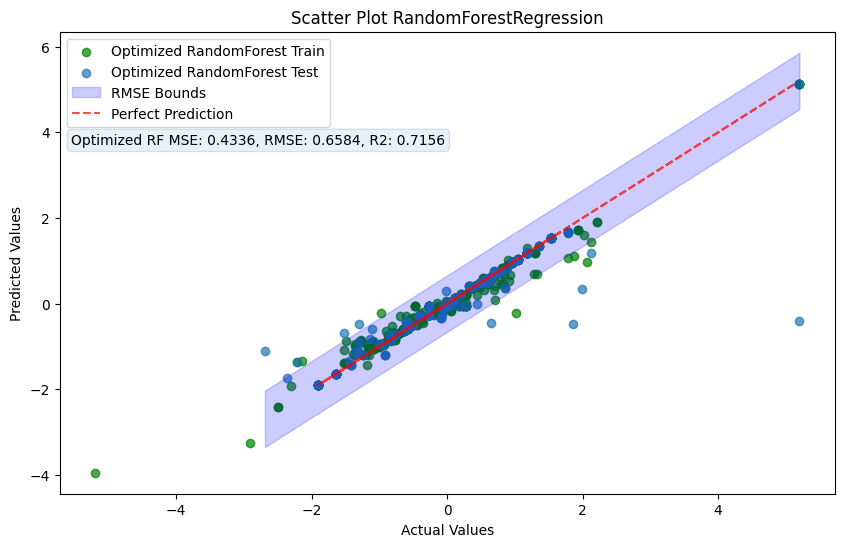

In [62]:
plt.figure(figsize=(10, 6))

# Scatter plot for training data
plt.scatter(y_train, y_pred_train_optimized, label='Optimized RandomForest Train', alpha=0.7, color='green')

# Scatter plot for test data
plt.scatter(y_test, y_test_pred_optimized, label='Optimized RandomForest Test', alpha=0.7)

# Scatter plot for test data with RMSE bounds
lower_bound_rf = np.sort(y_test - rmse_optimized)
upper_bound_rf = np.sort(y_test + rmse_optimized)
plt.fill_between(np.sort(y_test), lower_bound_rf, upper_bound_rf, color='blue', alpha=0.2, label='RMSE Bounds')

# Ideal prediction line
plt.plot(y_test_pred_optimized, y_test_pred_optimized, label='Perfect Prediction', linestyle='--', color='red', alpha=0.7)

# Text with metrics in the upper-left corner of the plot
text_optimized = f'Optimized RF MSE: {mse_optimized:.4f}, RMSE: {rmse_optimized:.4f}, R2: {r2_optimized:.4f}'
plt.text(0.015, 0.78, text_optimized, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', alpha=0.1))

# Display the plot
plt.title('Scatter Plot RandomForestRegression')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

# Кроссвалидация Bagging

In [63]:
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
import numpy as np

# Создаем базовую модель (например, DecisionTreeRegressor)
base_model = DecisionTreeRegressor()

# Создаем объект BaggingRegressor
bagging_model = BaggingRegressor(base_model, n_estimators=100, random_state=42)

# Выполняем кросс-валидацию
cv_scores = cross_val_score(bagging_model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

# Преобразуем отрицательные значения MSE в положительные
cv_rmse_scores = np.sqrt(-cv_scores)

# Выводим результаты кросс-валидации
print("Cross-Validation RMSE Scores:", cv_rmse_scores)
print("Mean RMSE:", np.mean(cv_rmse_scores))

Cross-Validation RMSE Scores: [0.42707882 0.58465909 0.89829092 0.31006934 0.45339858 0.40553928
 0.60477903 0.35143853 0.29568116 0.35144022]
Mean RMSE: 0.4682374966302116


In [68]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor

# Определяем пространство поиска гиперпараметров
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0]
}

# Создаем объект базовой модели
base_model = DecisionTreeRegressor()

# Создаем объект BaggingRegressor с указанием estimator
bagging_model = BaggingRegressor(base_estimator=base_model, random_state=42)

# Создаем объект GridSearchCV
grid_search = GridSearchCV(bagging_model, param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)

# Выполняем поиск по сетке
grid_search.fit(X_train, y_train)

# Выводим оптимальные гиперпараметры
print("Best Parameters:", grid_search.best_params_)

# Получаем лучшую модель
best_bagging_model = grid_search.best_estimator_

# Пересчитываем кросс-валидацию с использованием лучших параметров
cv_scores_optimized = cross_val_score(best_bagging_model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

# Преобразуем отрицательные значения MSE в положительные
cv_rmse_scores_optimized = np.sqrt(-cv_scores_optimized)

# Выводим результаты кросс-валидации до и после оптимизации
print("\nBefore Optimization:")
print("Cross-Validation RMSE Scores:", cv_rmse_scores)
print("Mean RMSE:", np.mean(cv_rmse_scores))

print("\nAfter Optimization:")
print("Cross-Validation RMSE Scores:", cv_rmse_scores_optimized)
print("Mean RMSE:", np.mean(cv_rmse_scores_optimized))

TypeError: BaggingRegressor.__init__() got an unexpected keyword argument 'base_estimator'

In [ ]:
# Обучаем оптимизированную модель
best_bagging_model.fit(X_train, y_train)

BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=200,
                 random_state=42)

In [ ]:
best_bagging_model.fit(X_train, y_train)  # Fit the model on the entire training set

# Making predictions on the training data
y_pred_train_optimized_bag = best_bagging_model.predict(X_train)

In [ ]:
# Получение предсказаний для тестовой выборки
y_test_pred_optimized_bag = best_bagging_model.predict(X_test)

# Расчет метрик для оптимизированной модели
mse_optimized_bag = mean_squared_error(y_test, y_test_pred_optimized_bag)
rmse_optimized_bag = np.sqrt(mse_optimized)
r2_optimized_bag = r2_score(y_test, y_test_pred_optimized_bag)

## Визуализации предсказаний Bagging

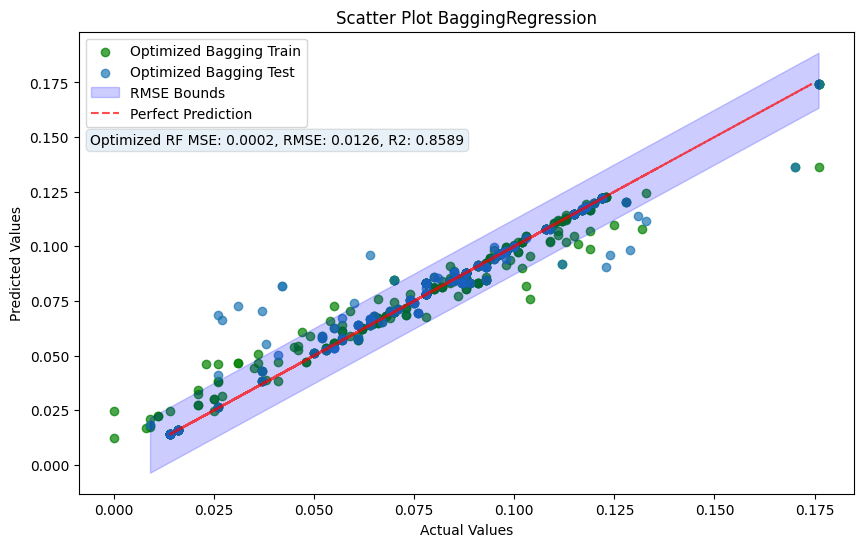

In [ ]:
plt.figure(figsize=(10, 6))

# Scatter plot for training data
plt.scatter(y_train, y_pred_train_optimized_bag, label='Optimized Bagging Train', alpha=0.7, color='green')

# Scatter plot for test data
plt.scatter(y_test, y_test_pred_optimized_bag, label='Optimized Bagging Test', alpha=0.7)

# Scatter plot for test data with RMSE bounds
lower_bound_rf = np.sort(y_test - rmse_optimized_bag)
upper_bound_rf = np.sort(y_test + rmse_optimized_bag)
plt.fill_between(np.sort(y_test), lower_bound_rf, upper_bound_rf, color='blue', alpha=0.2, label='RMSE Bounds')

# Ideal prediction line
plt.plot(y_test_pred_optimized_bag, y_test_pred_optimized_bag, label='Perfect Prediction', linestyle='--', color='red', alpha=0.7)

# Text with metrics in the upper-left corner of the plot
text_optimized = f'Optimized RF MSE: {mse_optimized_bag:.4f}, RMSE: {rmse_optimized_bag:.4f}, R2: {r2_optimized_bag:.4f}'
plt.text(0.015, 0.78, text_optimized, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', alpha=0.1))

# Display the plot
plt.title('Scatter Plot BaggingRegression')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

# Визуализации SHAP

In [69]:
import shap

# Создание explainer'ов
rf_explainer = shap.TreeExplainer(best_rf_model)

# Вместо TreeExplainer для Bagging используем KernelExplainer
bagging_explainer = shap.KernelExplainer(best_bagging_model.predict, X_train)

# Расчет SHAP-значений для тестового набора данных
shap_values_rf = rf_explainer.shap_values(X_test)
shap_values_bagging = bagging_explainer.shap_values(X_test)

# Построение SHAP-диаграммы для RandomForest
shap.summary_plot(shap_values_rf, X_test, feature_names=X_test.columns, show=False)
plt.title('SHAP Values for RandomForest')
plt.show()

# Построение SHAP-диаграммы для Bagging
shap.summary_plot(shap_values_bagging, X_test, feature_names=X_test.columns, show=False)
plt.title('SHAP Values for Bagging')
plt.show()

NameError: name 'best_bagging_model' is not defined